# Testing the Method on SANS-2D Data

## Setup

In [19]:
import numpy as np
import scipp as sc
import sciline
import scippneutron as scn
import plopp as pp
import esssans as sans
from esssans.types import *

import matplotlib.pyplot as plt

In [20]:
pipeline = sciline.Pipeline(
    sans.providers + sans.sans2d.providers,
    params=sans.sans2d.default_parameters,
)

In [21]:
pipeline[FileList[BackgroundRun]] = ['SANS2D00063159.hdf5']
pipeline.insert(sans.transmission_from_background_run)
pipeline[FileList[SampleRun]] = ['SANS2D00063114.hdf5']
pipeline.insert(sans.transmission_from_sample_run)
pipeline[FileList[EmptyBeamRun]] = ['SANS2D00063091.hdf5']
pipeline[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5'
pipeline[OutFilename] = 'reduced.nxs'

pipeline[WavelengthBins] = sc.linspace(
    'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
)

pipeline[sans.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')

mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
pipeline[WavelengthMask] = sc.DataArray(
    sc.array(dims=['wavelength'], values=[True]),
    coords={'wavelength': mask_interval},
)

pipeline[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
pipeline[NonBackgroundWavelengthRange] = sc.array(
    dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
)
pipeline[CorrectForGravity] = True
pipeline[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
pipeline[sans.ReturnEvents] = True

iofq = pipeline.get(BackgroundSubtractedIofQ)

## Explore the BackgroundSubtractedIofQ Output

This item apparently returns events.  Does it?  Examining this workflow it looks like it returns histogrammed data.  Examining the data in the output confirms this.

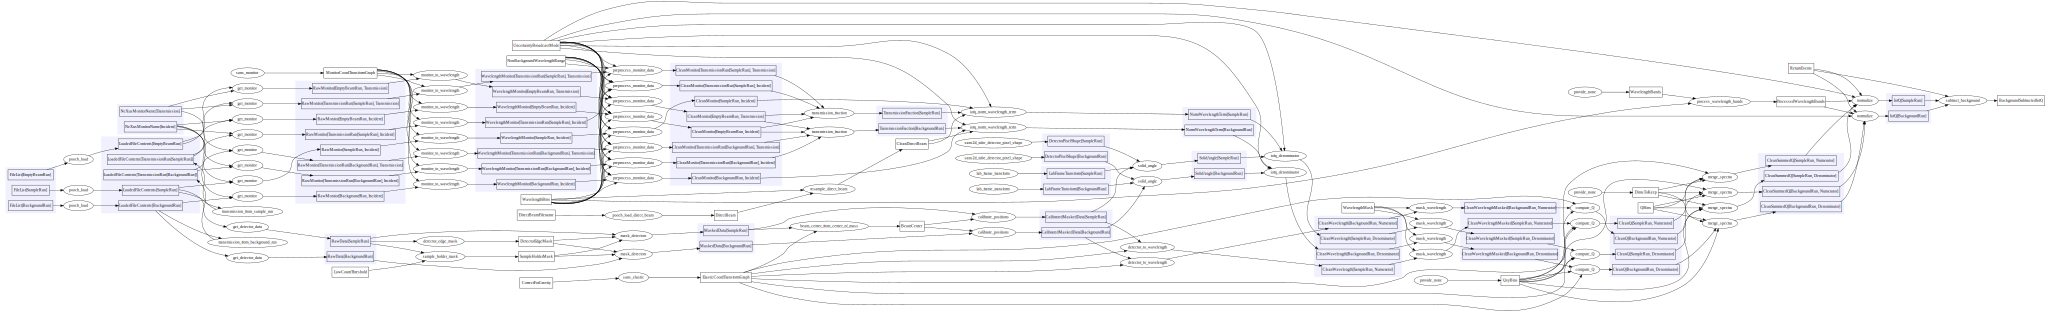

In [5]:
iofq.visualize(graph_attr={'rankdir': 'LR'})

## Get the Results

In [22]:
sampiq = pipeline.get(BackgroundSubtractedIofQ)
sampres = sampiq.compute()

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


### Initial exploration (not important)

In [7]:
print(sampres)

<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                          DataArrayView        <no unit>  (Q)  binned data: dim='event', content=DataArray(
          dims=(event: 6172466),
          data=float64[dimensionless],
          coords={'tof':float64[µs], 'pulse_time':datetime64[ns], 'wavelength':float64[Å],
                  'phi':float64[rad], 'Q':float64[1/Å]})




Note that the Q coords are bin edges, and the DataArrayView is "binned data".

Looking down at the data itself: 

In [8]:
svar = sampres.data
print(svar)

<scipp.Variable> (Q: 140)  DataArrayView        <no unit>  binned data: dim='event', content=DataArray(
          dims=(event: 6172466),
          data=float64[dimensionless],
          coords={'tof':float64[µs], 'pulse_time':datetime64[ns], 'wavelength':float64[Å],
                  'phi':float64[rad], 'Q':float64[1/Å]})


* We have there 140 Q values.
* It has no units
* but 6M events, and coords there has Q.  What is that?

In [9]:
sc.show(svar)

In [10]:
sc.show(svar[139])

In [11]:
sc.show(svar[0].values)

In [12]:
sc.show(svar[0].values.data)

In [13]:
print(svar[0].values.data[0])
print(svar[0].values.data[20000])

<scipp.Variable> ()    float64  [dimensionless]  0.003432  3.303e-05
<scipp.Variable> ()    float64  [dimensionless]  0.003432  3.303e-05


That's the Q value and the weight as a pair?
However, these data values are all the same within each bin?

In [12]:
# Simon Heybrock suggested this to extract the events:
print(sampres[0].value)
sc.show(sampres[0].value)

<scipp.DataArray>
Dimensions: Sizes[event:22015, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.014073, 0.0141408, ..., 0.0128737, 0.0141552]
* phi                       float64            [rad]  (event)  [-1.48244, -1.46791, ..., 1.27805, 1.638]
* pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:49:47.788024902, 2020-02-12T20:59:54.286010742, ..., 2020-02-14T05:38:44.839996337, 2020-02-14T05:56:34.838012695]
* tof                       float64            [µs]  (event)  [92788.1, 92477.4, ..., 85109, 79565.4]
* wavelength                float64             [Å]  (event)  [15.7654, 15.7126, ..., 14.4611, 13.5191]
Data:
                            float64  [dimensionless]  (event)  [0.003432, 0.003432, ..., -0.00235922, -0.00235922]  [3.303e-05, 3.303e-05, ..., 5.94507e-06, 5.94507e-06]




In [13]:
print(sampres[0].value[0])

<scipp.DataArray>
Dimensions: Sizes[]
Coordinates:
  Q                         float64           [1/Å]  ()  0.014073
  phi                       float64            [rad]  ()  -1.48244
  pulse_time              datetime64             [ns]  ()  2020-02-12T20:49:47.788024902
  tof                       float64            [µs]  ()  92788.1
  wavelength                float64             [Å]  ()  15.7654
Data:
                            float64  [dimensionless]  ()  0.003432  3.303e-05




In [14]:
print(sampres[0].value[0].coords['Q'].value) # The q value of the point
print(sampres[0].value[0].data.value) # the statistical weight?

0.014072992128883214
0.003431999959142457


## Continuing...

In [23]:
allevents = sampres.bins.concat().value
print(allevents)

<scipp.DataArray>
Dimensions: Sizes[event:6172466, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.014073, 0.0141408, ..., 0.593805, 0.594188]
* phi                       float64            [rad]  (event)  [-1.48244, -1.46791, ..., 2.41065, 2.3946]
* pulse_time              datetime64             [ns]  (event)  [2020-02-12T20:49:47.788024902, 2020-02-12T20:59:54.286010742, ..., 2020-02-12T21:03:12.386108398, 2020-02-12T20:38:54.589000701]
* tof                       float64            [µs]  (event)  [92788.1, 92477.4, ..., 11876.9, 11848.4]
* wavelength                float64             [Å]  (event)  [15.7654, 15.7126, ..., 2.01191, 2.0071]
Data:
                            float64  [dimensionless]  (event)  [0.003432, 0.003432, ..., 3.58915, 3.58915]  [3.303e-05, 3.303e-05, ..., 19.0887, 19.0887]




In [24]:
eventQ = allevents.coords['Q'].values
eventW = allevents.values
nans = np.isnan(eventW)
print(nans)
eventW[nans] = 0.0
print(eventW)

[False False False ... False False False]
[ 3.43199996e-03  3.43199996e-03  3.43199996e-03 ... -1.63057064e+00
  3.58914659e+00  3.58914659e+00]


140
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [70.3897, 72.4561, ..., 7.17829, 0]  [0.702995, 0.463153, ..., 38.1775, 0]




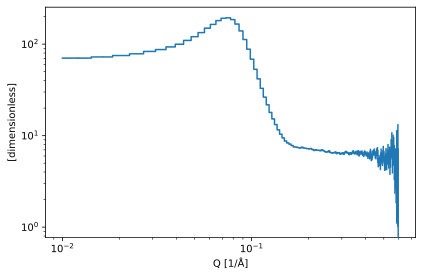

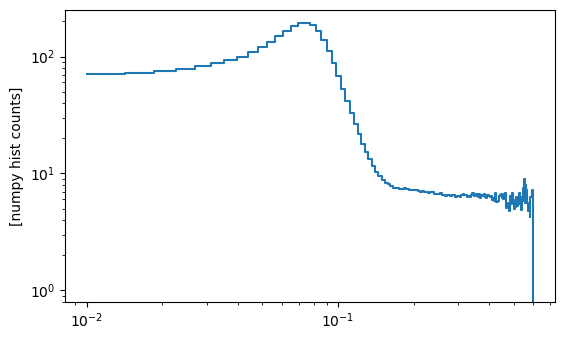

In [25]:
shst = sampres.hist()
print(shst.size)
print(shst)

scipp_bins = shst.coords['Q'].values
#print(scipp_bins.values)

hstw = np.histogram(eventQ, bins=scipp_bins, weights=eventW)
x_histw = hstw[1]
x_histw = x_histw[:-1]
y_histw = hstw[0]


hst = np.histogram(eventQ, bins=scipp_bins)#, weights=np.sqrt(eventW))
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)



scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

#plt.errorbar(x_histw, y_histw, yerr=e_histw, label='Weighted')
#plt.errorbar(x_hist, y_hist, yerr=e_hist, label='Unweighted')
plt.step(x_histw, y_histw, where='post', label='Weighted')
#plt.plot(x_hist, scl*y_hist, label=scltxt)
plt.yscale('log')
plt.xscale('log')
#plt.legend()
plt.ylim([0.8, 250])
plt.ylabel('[numpy hist counts]')
plt.tight_layout()

shst.plot(scale={'Q': 'log'}, norm='log')


I wouldn't say this is absolutely identical, but it looks close enough to work with.  

Also maybe the bins are not optimal in scipp, and there are some odd artefacts going on in scipp if I plot my own optimal histogram.

{'Q': 140}
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [70.3897, 72.4561, ..., 7.17829, 0]  [0.702995, 0.463153, ..., 38.1775, 0]




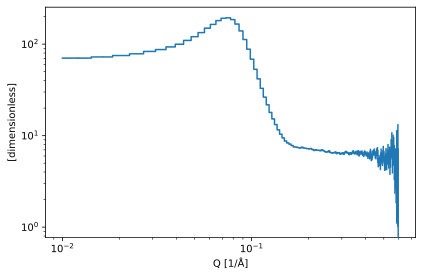

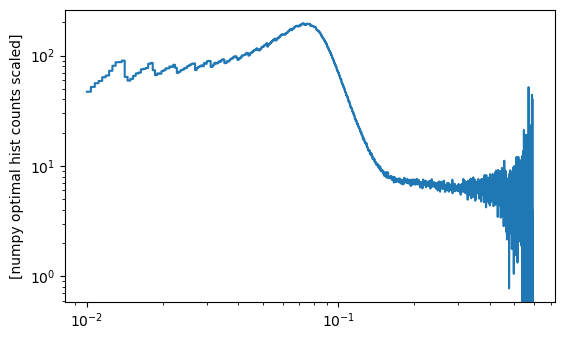

In [26]:
shst = sampres.hist()
print(shst.sizes)
print(shst)

scipp_bins = shst.coords['Q'].values
#print(scipp_bins.values)

nscipp_bins = shst.size


def optimal_linear_nbins(xevents):
    """
    Calculate optimal number of bins from Freedman-Diaconis rule
    https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram
    https://en.wikipedia.org/wiki/Freedman–Diaconis_rule
    """
    xmax = np.amax(xevents)
    xmin = np.amin(xevents)

    npts = xevents.size
    
    iqr = np.subtract(*np.percentile(xevents, [75, 25]))
    return int((xmax - xmin)*npts**(1.0/3.0)/(2.0*iqr))


study_data = eventQ

opt_n_bin = optimal_linear_nbins(study_data)

event_xmax = np.amax(study_data)
event_xmin = np.amin(study_data)

slic=(event_xmax-event_xmin)/(opt_n_bin+1)
hbins = np.arange(event_xmin, event_xmax, slic)

hscale =  float(opt_n_bin) /float(nscipp_bins)

hst = np.histogram(study_data, bins=hbins, weights=eventW)
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

plt.step(x_hist, y_hist*hscale, where='post', label='Weighted')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('[numpy optimal hist counts scaled]')
plt.tight_layout()

shst.plot(scale={'Q': 'log'}, norm='log')


Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
aa            50        0      inf     None     True     None     None
bb            50        0      inf     None     True     None     None
bg1            5        0      100     None     True     None     None
bg2            5        0      100     None     True     None     None
kappa1      0.05    0.001      0.1     None     True     None     None
kappa2      0.05    0.001      0.1     None     True     None     None
q0          0.07     0.03      0.2     None     True     None     None
[[Model]]
    Model(lorg)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 144
    # data points      = 140
    # variables        = 6
    chi-square         = 881.953431
    reduced chi-square = 6.58174203
    Akaike info crit   = 269.669557
    Bayesian info crit = 287.319411
    R-squared          = 0.99687390
[[Variables]]
    aa:      3.67875956 +/- 0.29721758 (8.08%) (init = 50)
    bb:      7

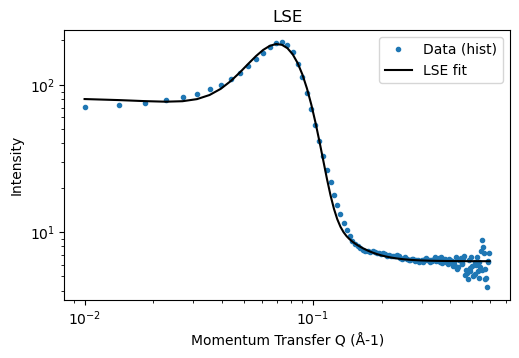

In [27]:
## Least Squares Fit of scipp histo data

from lmfit import Model

from scipy.special import erfc
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def cauchy_cubed_integral(x1, x2, kappa):
    # Returns the integral of a cauchy-cubed distribution between two x values
    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    denom = 8.0 * np.pi**3.0 * kappa**2.0
    
    t1 = kappa * (3.0 * xmax**3.0 + 5.0 * xmax * kappa**2.0) / ( xmax**2.0 + kappa**2.0)**2.0
    t2 = kappa * (3.0 * xmin**3.0 + 5.0 * xmin * kappa**2.0) / (xmin**2.0 + kappa**2.0)**2.0
    t3 = 3.0 * np.arctan(xmax / kappa)
    t4 = 3.0 * np.arctan(xmin / kappa)

    result = (-t1 + t2 -t3 + t4)/denom
    
    
    return np.absolute(result)
    


def uniform_integral(x1, x2):
    # Returns the integral over the range of x values
    # Assume y=1 over the range

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    intg = norm.cdf(x1, loc=mu, scale=sigma) - norm.cdf(x2, loc=mu, scale=sigma)
    
    return np.absolute(intg)



def dlor(x, aa, bb, kappa1, kappa2, q0, bg):
    # Double lorentzian model
    return aa/(kappa1*kappa1 + x*x) + bb / (kappa2*kappa2 + (x-q0)**2.0) + bg

dlorm = Model(dlor)
dlorparams = dlorm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)

def lor2p(x, aa, bb, kappa1, kappa2, q0, bg1, bg2):
    # A piecewise lorentzian and lorentzian squared
    lor2 = bb/(kappa2*kappa2 + (x-q0)**2.0)**2.0
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    res = lor+bg1
    mask = np.where(x>q0)
    res[mask] = lor2[mask]+bg2
    return res

lor2pm = Model(lor2p)
lor2pparams = lor2pm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg1=dict(value=5, min=0.0, max=100.0),
    bg2=dict(value=5, min=0.0, max=100.0)
)


def lor2(x, aa, bb, kappa1, kappa2, q0, bg):
    # A shifted lorentzian and lorentzian squared
    lor2 = bb/(kappa2*kappa2 + (x-0.0)**2.0)**2.0
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    res = lor+lor2+bg
    return res

lor2m = Model(lor2)
lor2params = lor2m.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0)
)



def lorgpw(x, aa, bb, kappa1, kappa2, q0, bg1, bg2):
    # Piecewise lorentzian and gaussian with two separate bg terms
    # Best so far but complete nonsense
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    gau = bb * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)
    res = lor+bg1
    mask = np.where(x>q0)
    res[mask] = gau[mask]+bg2
    return res

lorgpwm = Model(lorgpw)

lorgpwparams = lorgpwm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg1=dict(value=5, min=0.0, max=100.0),
    bg2=dict(value=5, min=0.0, max=100.0)
)

lorgpwparams.pretty_print()

def lorg(x, aa, bb, kappa1, kappa2, q0, bg):
    # Gaussian sitting on a lorentzian type term (powered)
    #ll = aa/(kappa1*kappa1 + x*x)**3.0
    #gg = bb * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)

    ll = aa * cauchy.pdf(x, scale=kappa1, loc=0.0)**3.0 / cauchy_cubed_integral(lse_data_range[0], lse_data_range[1], kappa1)
    gg = bb * norm.pdf(x, scale=kappa2, loc=q0) / gaussian_integral(lse_data_range[0], lse_data_range[1], q0, kappa2)
    flt = bg / uniform_integral(data_range[0], data_range[1])
    
    return  ll + gg + flt

lorgm = Model(lorg)
lorgparams = lorgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)



def lormodg(x, aa, bb, tau, kappa1, kappa2, q0, bg):
    # Modified Gaussian sitting on a lorentzian type term (powered)
    # See http://dx.doi.org/10.6028/jres.119.003
    # Bragg peaks are only gaussian when not sample-spread
    ll = aa/(kappa1*kappa1 + x*x)**2.0
    gg = bb * (tau/2.0) * np.exp( 0.5*tau*tau*kappa2*kappa2 + tau*(q0-x)) * erfc( - ((x-q0) / (np.sqrt(2.0)*kappa2)) + tau*kappa2 / np.sqrt(2.0))
    return  ll + gg + bg

lormodgm = Model(lormodg)
lormodgparams = lormodgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    tau=dict(value=0.1, min=0.01, max=0.1),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)









def dg(x, aa, bb, kappa1, kappa2, q0, bg):
    # Two gaussians
    g1 = aa * (1.0 / (kappa1 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - 0.0)/kappa1)**2.0)
    g2 = bb * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)
    return  g1 + g2 + bg

dgm = Model(dg)
dgparams = dgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0),
)



def threec(x, aa, bb, cc, kappa1, kappa2, q0, bg):
    # Three component piecewise model with one background
    lor = aa/(kappa1*kappa1 + (x-q0)**2.0)
    lor2 = bb/(kappa1*kappa1 + (x-q0)**2.0)**2.0
    gau = cc * (1.0 / (kappa2 * np.sqrt(2.0 * np.pi))) * np.exp(-0.5 * ((x - q0)/kappa2)**2.0)
    res = lor + lor2 + bg
    mask = np.where(x>q0)
    res[mask] = gau[mask] + lor2[mask] + bg
    return res

threecm = Model(threec)

threecparams = threecm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    cc=dict(value=50.0, min=0.0),\
    kappa1=dict(value=0.05, min=0.001, max=0.1),\
    kappa2=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),
    bg=dict(value=5, min=0.0, max=100.0)
)





lmm = lorgm
params = lorgparams

lse_data_range = np.array([np.amin(x_histw), np.amax(x_histw)])
data_range = lse_data_range
result = lmm.fit(y_histw, params, x=x_histw)#, weights = 1.0/e_histw)


print(result.fit_report())

fig, ax = plt.subplots()
ax.plot(x_histw, y_histw, marker='.', ls='none', label="Data (hist)")
ax.plot(x_histw, result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('LSE')
ax.legend()

sample_lse_x = x_histw
sample_lse_pmf = result.best_fit

ax.set_xlabel('Momentum Transfer Q (Å-1)')
ax.set_ylabel('Intensity')

#plt.savefig('twocomponent-lse-fit.png', bbox_inches='tight')
plt.show()

#lsq2 = result.best_values['q2']
#lskappa = result.best_values['kappa']
#lskappae = result.result.uvars["kappa"].std_dev
#lsq0 = result.best_values['q0']
#lsq0e= result.result.uvars["q0"].std_dev

# kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

kappaSampleLSE = result.best_values['kappa1']
kappaSampleLSEe = result.result.uvars["kappa1"].std_dev
sigmaLSE = result.best_values['kappa2']
sigmaLSEe = result.result.uvars["kappa2"].std_dev
q0LSE = result.best_values['q0']
q0LSEe = result.result.uvars["q0"].std_dev
sampaaLSE = result.best_values['aa']
ggLSE = result.best_values['bb']
sampbgLSE = result.best_values['bg']


That isn't perfect but it's the best of the bunch.  Now we need a model for the background.

In [11]:
siq = pipeline.get(IofQ[SampleRun])
sres= siq.compute()
bgiq = pipeline.get(IofQ[BackgroundRun])
bgres = bgiq.compute()

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.
An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


In [12]:
allsevents = sres.bins.concat().value
allbgevents = bgres.bins.concat().value
print(allbgevents)

<scipp.DataArray>
Dimensions: Sizes[event:99205, ]
Coordinates:
* Q                         float64           [1/Å]  (event)  [0.0139289, 0.0139563, ..., 0.585179, 0.591361]
* phi                       float64            [rad]  (event)  [-1.56199, -1.7183, ..., 2.36995, 2.37299]
* pulse_time              datetime64             [ns]  (event)  [2020-02-14T05:45:58.838989257, 2020-02-14T05:42:03.839019775, ..., 2020-02-14T06:05:00.837036132, 2020-02-14T05:40:45.438995361]
* tof                       float64            [µs]  (event)  [88027.7, 83397.7, ..., 12089.2, 11820.7]
* wavelength                float64             [Å]  (event)  [14.9567, 14.1702, ..., 2.04783, 2.0025]
Data:
                            float64  [dimensionless]  (event)  [0.00235922, 0.00235922, ..., 1.12811, 1.63057]  [5.94507e-06, 5.94507e-06, ..., 1.61637, 3.00454]




In [13]:
seventQ = allsevents.coords['Q'].values
seventW = allsevents.values
bgeventQ = allbgevents.coords['Q'].values
bgeventW = allbgevents.values

nans = np.isnan(bgeventW)
bgeventW[nans] = 0.0
msk = np.where(bgeventW < 0.0)
bgeventW[msk] = 0.0

nans = np.isnan(seventW)
seventW[nans] = 0.0
msk = np.where(seventW < 0.0)
seventW[msk] = 0.0


140
<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.01, 0.0142143, ..., 0.595786, 0.6]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2, 16]
Data:
                            float64  [dimensionless]  (Q)  [2.10442, 1.35467, ..., 0, 0]  [0.005303, 0.00203108, ..., 0, 0]




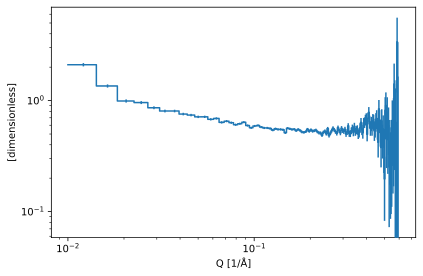

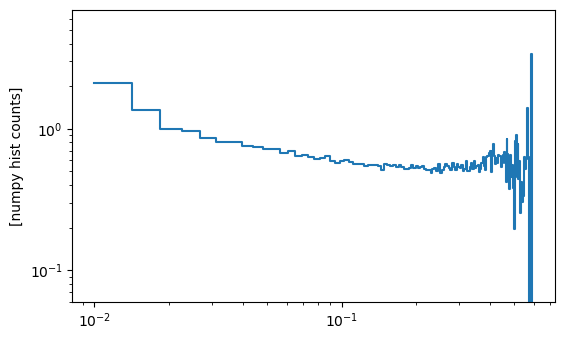

In [15]:
bghst = bgres.hist()
print(bghst.size)
print(bghst)

scipp_bgbins = bghst.coords['Q'].values
#print(scipp_bins.values)

bgnhstw = np.histogram(bgeventQ, bins=scipp_bgbins, weights=bgeventW)
x_bgnhistw = bgnhstw[1]
x_bgnhistw = x_bgnhistw[:-1]
y_bgnhistw = bgnhstw[0]


bgnhst = np.histogram(bgeventQ, bins=scipp_bgbins)#, weights=np.sqrt(eventW))
x_bgnhist= bgnhst[1]
x_bgnhist = x_bgnhist[:-1]
y_bgnhist = bgnhst[0]
e_bgnhist = np.sqrt(y_bgnhist)



scl = 0.001

scltxt = "Unweighted (scale = " + str(scl) + ")"

plt.rcParams["figure.figsize"] = (5.75,3.5)

#plt.errorbar(x_histw, y_histw, yerr=e_histw, label='Weighted')
#plt.errorbar(x_hist, y_hist, yerr=e_hist, label='Unweighted')
plt.step(x_bgnhistw, y_bgnhistw, where='post', label='Weighted')
#plt.plot(x_hist, scl*y_hist, label=scltxt)
plt.yscale('log')
plt.xscale('log')
#plt.legend()
plt.ylim([0.06, 6.9])
plt.ylabel('[numpy hist counts]')
plt.tight_layout()

bghst.plot(scale={'Q': 'log'}, norm='log')

[[Model]]
    Model(lorbg)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 140
    # variables        = 3
    chi-square         = 12.3512033
    reduced chi-square = 0.09015477
    Akaike info crit   = -333.904451
    Bayesian info crit = -325.079524
    R-squared          = 0.21301925
[[Variables]]
    aa:     0.01711247 +/- 0.00519041 (30.33%) (init = 50)
    kappa:  0.00496993 +/- 0.00696720 (140.19%) (init = 0.05)
    bg:     0.33787074 +/- 0.01570152 (4.65%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(aa, kappa) = +0.8408
    C(aa, bg)    = -0.3183
    C(kappa, bg) = -0.2406


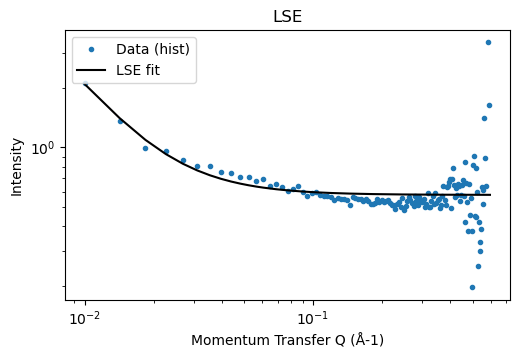

In [16]:
## Least Squares Fit of scipp histo background data

from lmfit import Model

from scipy.special import erfc


def lorbg(x, aa, kappa, bg):
    # Single lorentzian model with bg
    lorpart = aa * cauchy.pdf(x, scale=kappa, loc=0.0)/cauchy_integral(lse_data_range[0], lse_data_range[1], kappa)
    flatpart = bg / uniform_integral(lse_data_range[0], lse_data_range[1])
    return lorpart + flatpart

lorbgm = Model(lorbg)
lorbgparams = lorbgm.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa=dict(value=0.05, min=0.001, max=0.1),\
    bg=dict(value=5, min=0.0, max=100.0)
)


def lor2(x, aa, bb, kappa, bg):
    # A shifted lorentzian and lorentzian squared
    lor2 = bb/(kappa*kappa + x**2.0)**2.0
    lor = aa/(kappa*kappa + x**2.0)
    res = lor+lor2+bg
    return res

lor2m = Model(lor2)
lor2params = lor2m.make_params(
    aa=dict(value=50.0, min=0.0),\
    bb=dict(value=50.0, min=0.0),\
    kappa=dict(value=0.05, min=0.001, max=0.1),\
    bg=dict(value=5, min=0.0, max=100.0)
)


def expf(x, aa, kappa, bg):
    # Double lorentzian model
    return aa * np.exp(-(x/kappa)) + bg

expm = Model(expf)
expparams = expm.make_params(
    aa=dict(value=50.0, min=0.0),\
    kappa=dict(value=0.05, min=0.001, max=0.1),\
    bg=dict(value=5, min=0.0, max=100.0),
)


lmm = lorbgm
params = lorbgparams

lse_data_range = np.array([\
    np.amin(x_bgnhistw),\
    np.amax(x_bgnhistw)])

data_range = lse_data_range
result = lmm.fit(y_bgnhistw, params, x=x_bgnhistw)#, weights = 1.0/e_histw)


print(result.fit_report())

fig, ax = plt.subplots()
ax.plot(x_bgnhistw, y_bgnhistw, marker='.', ls='none', label="Data (hist)")
ax.plot(x_bgnhistw, result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('LSE')
ax.legend()

bg_lse_x = x_bgnhistw
bg_lse_pmf = result.best_fit

ax.set_xlabel('Momentum Transfer Q (Å-1)')
ax.set_ylabel('Intensity')

#plt.savefig('twocomponent-lse-fit.png', bbox_inches='tight')
plt.show()

#lsq2 = result.best_values['q2']
#lskappa = result.best_values['kappa']
#lskappae = result.result.uvars["kappa"].std_dev
#lsq0 = result.best_values['q0']
#lsq0e= result.result.uvars["q0"].std_dev

# kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

kappaBGLSE = result.best_values['kappa']
BGaaLSE = result.best_values['aa']
BGbgLSE = result.best_values['bg']

We now have all the weights for each term from LSE, but we need to normalise them.  The normalisation comes after the definition of log-likelihood below...

In [17]:
m0LSE = sampaaLSE
m1LSE = ggLSE 
m2LSE = BGaaLSE 
mXLSE = BGbgLSE + sampbgLSE

print(m0LSE)
print(m1LSE)
print(m2LSE)
print(mXLSE)


3.6787595615300006
7.611233560666424
0.017112467257276
4.0560182627877195


In [18]:
evs = np.concatenate((seventQ, bgeventQ))
wts = np.concatenate((seventW, bgeventW))

## EMTK Object Oriented API Analysis

An interpolation is being performed on the direct_beam function. The variances in the direct_beam function will be dropped.


Analyser object created with 6073261 weighted events in range 0.010000018765608024 - 0.5941878658588073


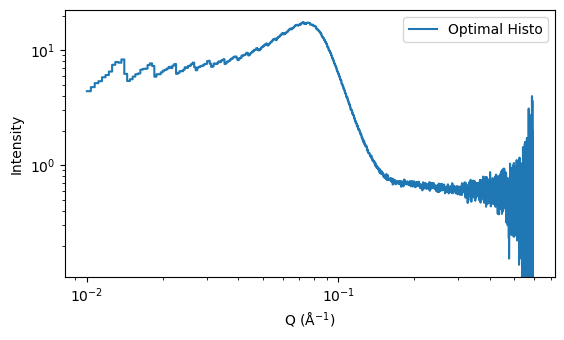

In [213]:
import numpy as np
import scipp as sc
import sciline
import scippneutron as scn
import plopp as pp
import esssans as sans
from esssans.types import *

import matplotlib.pyplot as plt



def getWeightedSans2DEvents():
    """ Performs a super-lean version of the whole of the 
        above scipp data processing in one function.
    Returns:
        evs: numpy array of event Q values
        wts: numpy array of event weights
    """
    
    pipeline = sciline.Pipeline(
    sans.providers + sans.sans2d.providers,
    params=sans.sans2d.default_parameters,
    )

    pipeline[FileList[BackgroundRun]] = ['SANS2D00063159.hdf5']
    pipeline.insert(sans.transmission_from_background_run)
    pipeline[FileList[SampleRun]] = ['SANS2D00063114.hdf5']
    pipeline.insert(sans.transmission_from_sample_run)
    pipeline[FileList[EmptyBeamRun]] = ['SANS2D00063091.hdf5']
    pipeline[DirectBeamFilename] = 'DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5'
    pipeline[OutFilename] = 'reduced.nxs'
    
    pipeline[WavelengthBins] = sc.linspace(
        'wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
    )
    
    pipeline[sans.sans2d.LowCountThreshold] = sc.scalar(100, unit='counts')
    
    mask_interval = sc.array(dims=['wavelength'], values=[2.21, 2.59], unit='angstrom')
    pipeline[WavelengthMask] = sc.DataArray(
        sc.array(dims=['wavelength'], values=[True]),
        coords={'wavelength': mask_interval},
    )
    
    pipeline[QBins] = sc.linspace(dim='Q', start=0.01, stop=0.6, num=141, unit='1/angstrom')
    pipeline[NonBackgroundWavelengthRange] = sc.array(
        dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
    )
    pipeline[CorrectForGravity] = True
    pipeline[UncertaintyBroadcastMode] = UncertaintyBroadcastMode.upper_bound
    pipeline[sans.ReturnEvents] = True

    siq = pipeline.get(IofQ[SampleRun])
    sres= siq.compute()
    
    allsevents = sres.bins.concat().value


    seventQ = allsevents.coords['Q'].values
    seventW = allsevents.values
        
    nans = np.isnan(seventW)
    seventW[nans] = 0.0
    msk = np.where(seventW < 0.0)
    seventW[msk] = 0.0

    return seventQ, seventW




import emtk.EventModeAnalyser.Analyser as ema

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform


""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

def cauchy_cubed_integral(x1, x2, kappa):
    # Returns the integral of a cauchy-cubed distribution between two x values
    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    denom = 8.0 * np.pi**3.0 * kappa**2.0
    
    t1 = kappa * (3.0 * xmax**3.0 + 5.0 * xmax * kappa**2.0) / ( xmax**2.0 + kappa**2.0)**2.0
    t2 = kappa * (3.0 * xmin**3.0 + 5.0 * xmin * kappa**2.0) / (xmin**2.0 + kappa**2.0)**2.0
    t3 = 3.0 * np.arctan(xmax / kappa)
    t4 = 3.0 * np.arctan(xmin / kappa)

    result = (-t1 + t2 -t3 + t4)/denom
    
    
    return np.absolute(result)
    


def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    intg = norm.cdf(x1, loc=mu, scale=sigma) - norm.cdf(x2, loc=mu, scale=sigma)
    
    return np.absolute(intg)


import emtk.EventModeAnalyser.Analyser

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
from importlib import reload
reload(emtk.EventModeAnalyser.Analyser) 

evs, wts = getWeightedSans2DEvents()

ema1 = ema.Analyser(evs, wts)

ema1.plot_histogram()
#ema1.plot_kde()

Least squares model function defined.


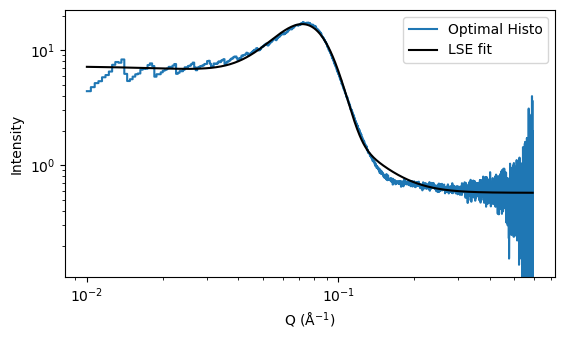

['amplitude', 'kappaSample', 'sigma', 'q0', 'kappaBG', 'm1', 'm2', 'm3']
[1.36901009e+00 1.22335709e-01 1.81079338e-02 7.33261286e-02
 1.08832352e-01 3.03931723e-01 4.94876357e-09 4.50588946e-01]
[5.17250070e-03 1.60914902e-02 1.88946142e-04 1.19049700e-04
 9.86873705e+06 3.86383470e-01 1.84223872e-01 1.06663442e-02]


In [214]:
def big_lse_pdf(x, amplitude, kappaSample, sigma, q0, kappaBG, m1, m2, m3):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3]))

    lor3 = mvals[0] * cauchy.pdf(x, scale=kappaSample, loc=0.0)**3.0 / cauchy_cubed_integral(ema1.xmin, ema1.xmax,kappaSample)
    lorbg= mvals[1] * cauchy.pdf(x, scale=kappaBG, loc=0.0)/cauchy_integral(ema1.xmin, ema1.xmax, kappaBG)
    gauss= mvals[2] * norm.pdf(x, scale=sigma, loc=q0) / gaussian_integral(ema1.xmin,ema1.xmax, q0, sigma)
    flt =  mvals[3] / uniform_integral(ema1.xmin, ema1.xmax)

    sol = amplitude *( lor3 + lorbg + gauss + flt)
    
    return sol


ema1.set_lse_function(big_lse_pdf)

ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    kappaSample=dict(value=0.05, min=0.001, max=1.0),\
    sigma=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),\
    kappaBG=dict(value=0.05, min=0.001, max=1.0),\
    m1=dict(value=0.1, min=0.0, max = 1.0),\
    m2=dict(value=0.1, min=0.0, max = 1.0),\
    m3=dict(value=0.1, min=0.0, max = 1.0)
)

ema1.lse_fit()
ema1.plot_LSE_fit()

pvals = ema1.get_lse_param_values()
psigs = ema1.get_lse_param_sigmas()
pnams = ema1.get_lse_param_names()

print(pnams)
print(pvals)
print(psigs)

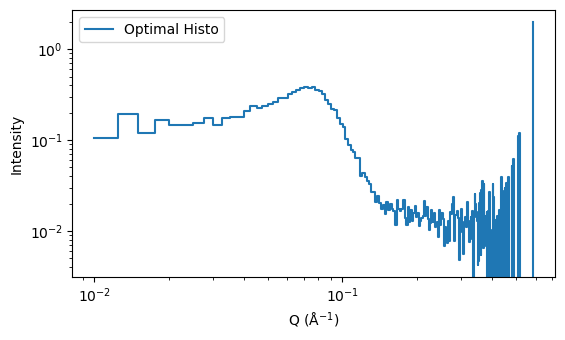

In [215]:
cpo = ema1.subsample(20000)
cpo.plot_histogram()

Calculating KDE


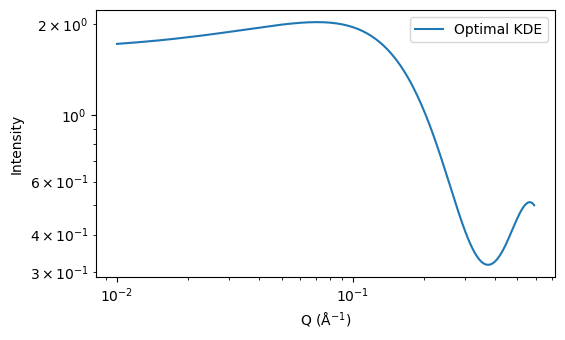

In [216]:
cpo.plot_kde()

In [217]:
# Build MCMC Models with API

def simplex_weights(Qraw):
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
                
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
        
    if 0.001 < kappaSample < 1.0 and\
    0.001 < sigma < 0.1 and\
    0.001 < q0 < 0.4 and\
    0.001 < kappaBG < 1.0 and\
    0.0 < m1 < 1.0 and\
    0.0 < m2 < 1.0 and\
    0.0 < m3 < 1.0 and\
    m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin

    
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    
    
    signal = cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0
    background = cauchy.pdf(xx, loc=0.0, scale = kappaBG)
    gauss = norm.pdf(xx, loc=q0, scale = sigma)
    unif = uniform.pdf(xx, loc=xmin, scale = xmax)
    
    term1 = mvals[0] * signal / sig_int
    term2 = mvals[1] * background / bg_int
    term3 = mvals[2] * gauss / gauss_int
    term4 = mvals[3] * 1.0 / uniform_int
    
            
    if verbose:
        print("xmin:", self.xmin)
        print("xmax:", self.xmax)
        print("Signal:", signal)
        print("Background:", background)
        print("Gauss:", gauss)
        print("Gauss:", gauss)
        print("sig_int:", sig_int)
        print("bg_int:", bg_int)
        print("mvals:", mvals)
    
    result = (term1 + term2 + term3 + term4)**use_weights
    
    return result




def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    sig_int = cauchy_cubed_integral(xmin, xmax, kappaSample)
    bg_int = cauchy_integral(xmin, xmax, kappaBG)
    gauss_int = gaussian_integral(xmin, xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(xmin, xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    

    signal = mvals[0]*cauchy.pdf(data, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = mvals[1]*cauchy.pdf(data, loc=0.0, scale = kappaBG) / bg_int
    gauss = mvals[2]*norm.pdf(data, loc=q0, scale = sigma) / gauss_int
    unif = mvals[3] / uniform_int

    

    ll = np.log(signal)
    lbg = np.log(background)
    lgauss = np.log(gauss)
    lunif = np.log(unif)

    # logaddexp is used to add the two components in linear space
    # in theory I suppose you can do it before taking the log above...
    ll1 = np.logaddexp(ll, lbg)
    ll2 = np.logaddexp(ll1, lunif)
    ll3 = np.logaddexp(ll2, lgauss)
    ll4 = np.sum(ll3 * use_weights)
        
    result = lp + ll4
    
    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        if verbose:
            print("mvals", mvals)
            print("signal", signal)
            print("background", background)
            print("gauss", gauss)
            print("uniform", unif)
            print("sig_int", sig_int)
            print("bg_int", bg_int)
            print("gauss_int", gauss_int)
            print("uniform_int", uniform_int)
        
    return result


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

cpo.lse_fit()
cpo.theta_seed = cpo.get_lse_param_values()
cpo.theta_seed = cpo.theta_seed[1:]
cpo.MCMC_fit()

MCMC launch
Burn in:


 66%|██████████████████████████████████████████████████████████████▋                                | 33/50 [00:01<00:00, 20.14it/s]/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2529/2637714614.py:124: RuntimeWarning: divide by zero encountered in log
  lgauss = np.log(gauss)
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.03it/s]


Sampling:


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.27it/s]


Calculating KDE


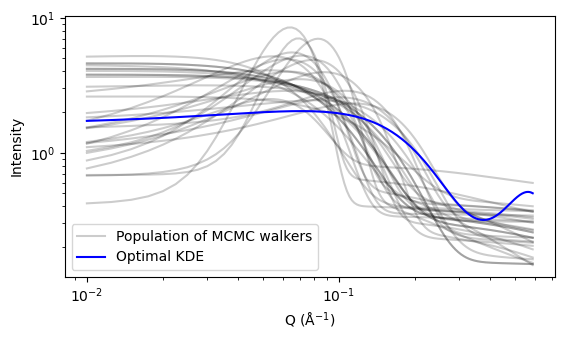

In [218]:
cpo.plot_MCMC_fit()

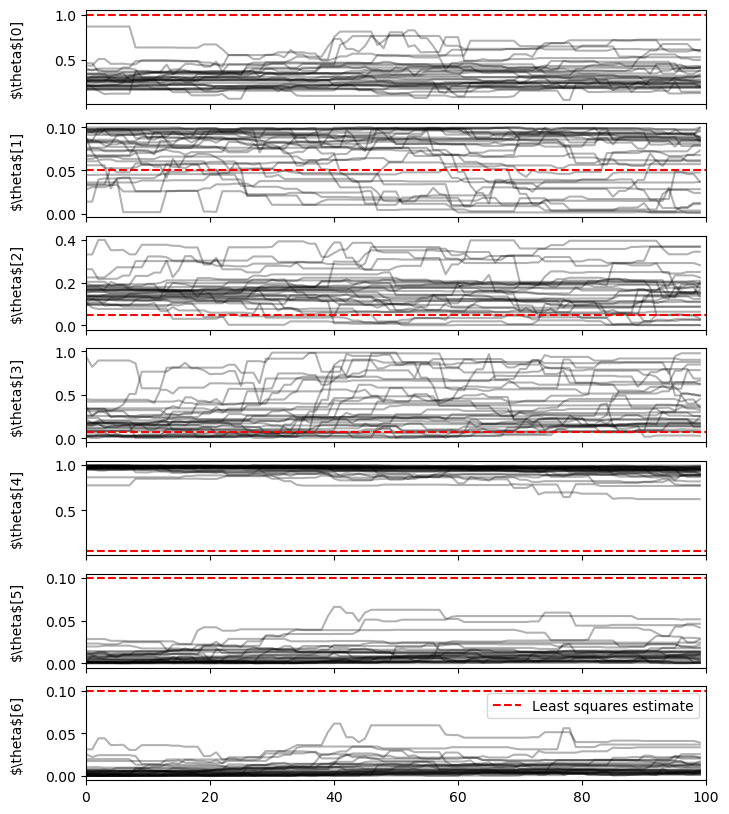

In [212]:
cpo.plot_MCMC_convergences()

## Preliminary manual analysis - in progress

In [137]:
opt_n_bin = optimal_linear_nbins(evs)

event_xmax = np.amax(evs)
event_xmin = np.amin(evs)

slic=(event_xmax-event_xmin)/(opt_n_bin+1)
hbins = np.arange(event_xmin, event_xmax, slic)

#hscale =  float(opt_n_bin) /float(nscipp_bins)

hst = np.histogram(evs, bins=hbins, weights=wts)
x_hist= hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

plt.step(x_hist, y_hist, where='post', label='Weighted')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Counts')
plt.tight_layout()


NameError: name 'optimal_linear_nbins' is not defined

### Build a complete LSE model based on the individual terms above

[[Model]]
    Model(big_lse_pdf)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 150
    # data points      = 1551
    # variables        = 8
    chi-square         = 213.011602
    reduced chi-square = 0.13805029
    Akaike info crit   = -3063.21353
    Bayesian info crit = -3020.44029
    R-squared          = 0.99162306
[[Variables]]
    amplitude:    1.41888393 +/- 0.00551148 (0.39%) (init = 1)
    kappaSample:  0.12171618 +/- 0.00497225 (4.09%) (init = 0.05)
    sigma:        0.01808454 +/- 1.4296e-04 (0.79%) (init = 0.05)
    q0:           0.07334868 +/- 8.4525e-05 (0.12%) (init = 0.07)
    kappaBG:      0.55989797 +/- 1.3099e+08 (23395251164.70%) (init = 0.05)
    m1:           0.29846721 +/- 0.01704496 (5.71%) (init = 0.1)
    m2:           6.2246e-10 +/- 0.15052578 (24182316406.18%) (init = 0.1)
    m3:           0.43983223 +/- 0.00687557 (1.56%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappaBG, m2)          = -0.979

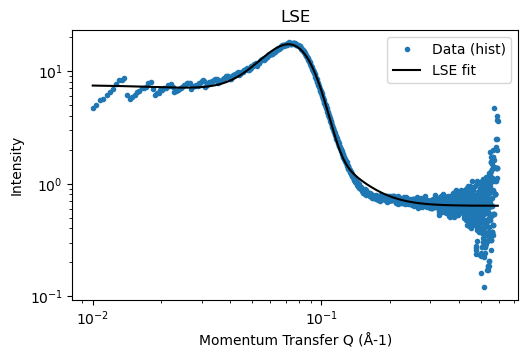

In [58]:

from lmfit import Model

from scipy.special import erfc

def simplex_weights(Qraw):
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
                
    return Qvals


def big_lse_pdf(x, amplitude, kappaSample, sigma, q0, kappaBG, m1, m2, m3):
    
    # Single lorentzian model with bg
    mvals = simplex_weights(np.array([m1, m2, m3]))

    lor3 = mvals[0] * cauchy.pdf(x, scale=kappaSample, loc=0.0)**3.0 / cauchy_cubed_integral(lse_data_range[0], lse_data_range[1],kappaSample)
    lorbg= mvals[1] * cauchy.pdf(x, scale=kappaBG, loc=0.0)/cauchy_integral(lse_data_range[0], lse_data_range[1], kappaBG)
    gauss= mvals[2] * norm.pdf(x, scale=sigma, loc=q0) / gaussian_integral(lse_data_range[0], lse_data_range[1], q0, sigma)
    flt =  mvals[3] / uniform_integral(data_range[0], data_range[1])

    sol = amplitude *( lor3 + lorbg + gauss + flt)
    
    return sol

big_lse_model = Model(big_lse_pdf)
big_lse_params = big_lse_model.make_params(
    amplitude=dict(value=1.0, min=0.0),\
    kappaSample=dict(value=0.05, min=0.001, max=1.0),\
    sigma=dict(value=0.05, min=0.001, max=0.1),\
    q0=dict(value=0.07, min=0.03, max=0.2),\
    kappaBG=dict(value=0.05, min=0.001, max=1.0),\
    m1=dict(value=0.1, min=0.0, max = 1.0),\
    m2=dict(value=0.1, min=0.0, max = 1.0),\
    m3=dict(value=0.1, min=0.0, max = 1.0)
)

lse_data_range = np.array([\
    np.amin(event_xmax),\
    np.amax(event_xmin)])

data_range = lse_data_range

result = big_lse_model.fit(y_hist, big_lse_params, x=x_hist)#, weights = 1.0/e_histw)


print(result.fit_report())

fig, ax = plt.subplots()
ax.plot(x_hist, y_hist, marker='.', ls='none', label="Data (hist)")
ax.plot(x_hist, result.best_fit, color='black', label="LSE fit")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('LSE')
ax.legend()

lse_x = x_hist
lse_pmf = result.best_fit

ax.set_xlabel('Momentum Transfer Q (Å-1)')
ax.set_ylabel('Intensity')

#plt.savefig('twocomponent-lse-fit.png', bbox_inches='tight')
plt.show()


mLSE = np.array

kappaSampleLSE = result.best_values['kappaSample']
sigmaLSE = result.best_values['sigma']
q0LSE = result.best_values['q0']
kappaBGLSE = result.best_values['kappaBG']
mLSE = np.array([ result.best_values['m1'],\
                 result.best_values['m2'],\
                 result.best_values['m3']])

#lsq2 = result.best_values['q2']
#lskappa = result.best_values['kappa']
#lskappae = result.result.uvars["kappa"].std_dev
#lsq0 = result.best_values['q0']
#lsq0e= result.result.uvars["q0"].std_dev

# kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

#kappaBGLSE = result.best_values['kappa']
#BGaaLSE = result.best_values['aa']
#BGbgLSE = result.best_values['bg']

Unit testing code...
l3 int: 30.10831399780596
	Cauchy-cubed CDF pass
	Cauchy CDF pass
	Gaussian CDF pass
	Simplex - inverse simplex consistency pass
mcmc [ 61.66550075 206.11864171]
lse [ 65.70590479 210.15904575]
lses [ 43.65351462 206.00230833]
lseb [22.05239017  4.15673742]
	Likelihood - logLikelihood consistency pass
Unit testing complete.
LSE data range: 0.010000018765608024 0.5934350464682222

Denominators / integrals:
	L3: 14.359697841860106
	bg: 0.21048559797475433
	gauss_norm 1.0
	uniform_norm 0.5834350277026141


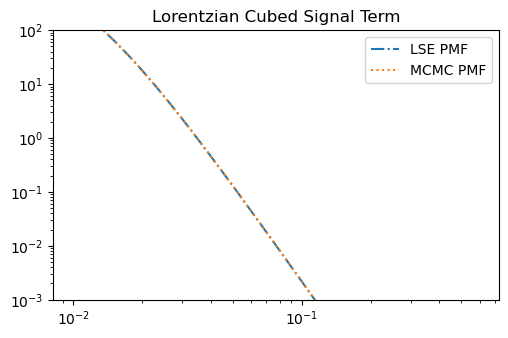

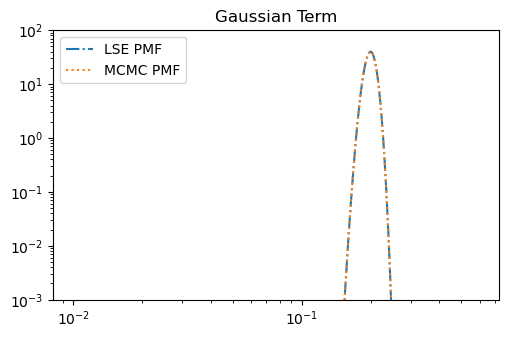

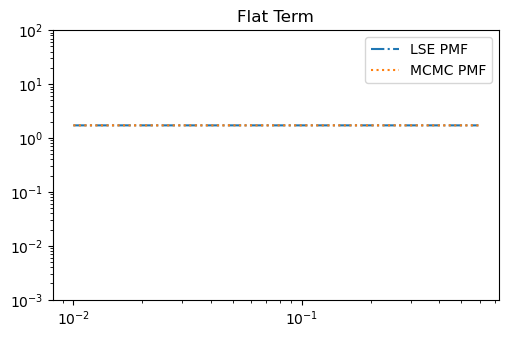

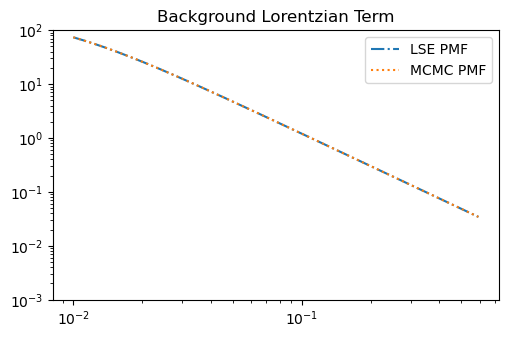

In [59]:
# Build the MCMC model

def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
        
    if 0.001 < kappaSample < 1.0 and\
    0.001 < sigma < 0.1 and\
    0.001 < q0 < 0.4 and\
    0.001 < kappaBG < 1.0 and\
    0.0 < m1 < 1.0 and\
    0.0 < m2 < 1.0 and\
    0.0 < m3 < 1.0 and\
    m1 + m2 + m3 < 1.0:
        return 0.0
    
    return -np.inf


def simplex_weights(Qraw):
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
                
    return Qvals


def unsimplex(mvalues):
    # The opposite of the simplex weight function above
    # The incoming mvalues are not necessarily normalised, 
    # unlike the simplex weight function output
    msum = np.sum(mvalues)
    mvalues = mvalues / msum # now they sum to 1
    m3 = np.take(mvalues, [0, 1, 2])
    return m3




def pmf(xx, theta, pweights=None,  verbose=False):
    
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = study_xmax-study_xmin

    
    sig_int = cauchy_cubed_integral(study_xmin, study_xmax, kappaSample)
    bg_int = cauchy_integral(study_xmin, study_xmax, kappaBG)
    gauss_int = gaussian_integral(study_xmin, study_xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(study_xmin, study_xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    
    
    signal = cauchy.pdf(xx, loc=0.0, scale = kappaSample)**3.0
    background = cauchy.pdf(xx, loc=0.0, scale = kappaBG)
    gauss = norm.pdf(xx, loc=q0, scale = sigma)
    unif = uniform.pdf(xx, loc=study_xmin, scale = study_xmax)
    
    term1 = mvals[0] * signal / sig_int
    term2 = mvals[1] * background / bg_int
    term3 = mvals[2] * gauss / gauss_int
    term4 = mvals[3] * 1.0 / uniform_int
    
            
    if verbose:
        print("xmin:", study_xmin)
        print("xmax:", study_xmax)
        print("Signal:", signal)
        print("Background:", background)
        print("Gauss:", gauss)
        print("Gauss:", gauss)
        print("sig_int:", sig_int)
        print("bg_int:", bg_int)
        print("mvals:", mvals)
    
    result = (term1 + term2 + term3 + term4)**use_weights
    
    return result




def log_likelihood(theta, verbose=False):
    kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    sig_int = cauchy_cubed_integral(study_xmin, study_xmax, kappaSample)
    bg_int = cauchy_integral(study_xmin, study_xmax, kappaBG)
    gauss_int = gaussian_integral(study_xmin, study_xmax, mu=q0, sigma=sigma)
    uniform_int = uniform_integral(study_xmin, study_xmax)

    mvals = simplex_weights(np.array([m1, m2, m3]))
    

    signal = mvals[0]*cauchy.pdf(study_data, loc=0.0, scale = kappaSample)**3.0 / sig_int
    background = mvals[1]*cauchy.pdf(study_data, loc=0.0, scale = kappaBG) / bg_int
    gauss = mvals[2]*norm.pdf(study_data, loc=q0, scale = sigma) / gauss_int
    #unif = mvals[3]*uniform.pdf(study_data, loc=study_xmin, scale = study_xmax) / uniform_int
    unif = mvals[3] / uniform_int

    

    ll = np.log(signal)
    lbg = np.log(background)
    lgauss = np.log(gauss)
    lunif = np.log(unif)

    # logaddexp is used to add the two components in linear space
    # in theory I suppose you can do it before taking the log above...
    ll1 = np.logaddexp(ll, lbg)
    ll2 = np.logaddexp(ll1, lunif)
    ll3 = np.logaddexp(ll2, lgauss)
    ll4 = np.sum(ll3 * study_weights)
        
    result = lp + ll4
    
    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        if verbose:
            print("mvals", mvals)
            print("signal", signal)
            print("background", background)
            print("gauss", gauss)
            print("uniform", unif)
            print("sig_int", sig_int)
            print("bg_int", bg_int)
            print("gauss_int", gauss_int)
            print("uniform_int", uniform_int)
        
    return result











# Make some unit tests of the code for consistency

def unit_tests():
    print("Unit testing code...")
         # kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
    pt = np.array([0.01, 0.01, 0.2, 0.008,  0.2, 0.2, 0.2])

    # Check the CDF values for cubic lorentzian
    cauchy_cubed_cdf_mathematica_check = cauchy_cubed_integral(0.001, 0.002, 0.01)
    print("l3 int:", cauchy_cubed_cdf_mathematica_check)
    assert np.isclose(cauchy_cubed_cdf_mathematica_check, 30.1083), f"Inconsistency between cauchy-cubed cdf and analytical {cauchy_cubed_cdf_mathematica_check, 30.1083}"
    print("\tCauchy-cubed CDF pass")

    # Check the CDF values for cauchy distribution
    cauchy_cdf_mathematica_check = cauchy_integral(0.001, 0.002, 0.01)
    assert np.isclose(cauchy_cdf_mathematica_check, 0.0311074), f"Inconsistency between cauchy cdf and analytical {cauchy_cdf_mathematica_check, 0.0311074}"
    print("\tCauchy CDF pass")

    # Check the CDF values for the gaussian distribution
    gauss_cdf_mathematica_check = gaussian_integral(0.001, 0.002, 0.001, 0.001)
    assert np.isclose(gauss_cdf_mathematica_check, 0.341345), f"Inconsistency between cauchy cdf and analytical {cauchy_cdf_mathematica_check, 0.341345}"
    print("\tGaussian CDF pass")

    # Check the consistency of the weight expansion and contraction functions (for unweighted data)
    initial_weights = np.array([0.2, 0.25, 0.3])
    four_weights = simplex_weights(initial_weights)
    three_weights = unsimplex(four_weights)
    assert np.isclose(initial_weights, three_weights).all(), f"Inconsistency between initial and unsimplexed weights {initial_weights, three_weights}"
    print("\tSimplex - inverse simplex consistency pass")

    pmfweights = np.array([pt[4], pt[5], pt[6]])
    pmfweights = simplex_weights(pmfweights)
    # Check that LSE PMF equals MCMC pmf for test locations

    lse_data_range = np.array([\
    np.amin(study_data),\
    np.amax(study_data)])
    
    # lorg(x, aa, bb, kappa1, kappa2, q0, bg)
    lsepmfs = lorg(study_data, pmfweights[0], pmfweights[2], pt[0], pt[1], pt[2], pmfweights[3])
    # lor(x, aa, kappa, bg):
    lsepmfb = lorbg(study_data, pmfweights[1], pt[3], pmfweights[3])
    lsepmf = lsepmfs + lsepmfb

    testpmf = pmf(study_data, pt)
    
    print("mcmc", testpmf)
    print("lse", lsepmf)
    print("lses", lsepmfs)
    print("lseb", lsepmfb)
    
    # Check the consistency between log(pdf) and log likelihood for two weighted data points 
    ll = log_likelihood(pt)
    lp = log_prior(pt)

    testpmf = pmf(study_data, pt, study_weights)
    sumll = lp + np.sum(np.log(testpmf))
    assert np.isclose(sumll, ll), f"Inconsistency between sum log pmf and log_likelihood {sumll, ll}"
    print("\tLikelihood - logLikelihood consistency pass")
    
    
    print("Unit testing complete.")


def graphical_tests():
    testx = x_hist

    # Only Signal Lorentzian3 Term
    thetaT = np.array([0.01, 0.01, 0.2, 0.008,  1.0, 0.0, 0.0])
    lsey = lorg(testx, 1.0, 0.0, 0.01, 0.01, 0.2, 0.0)
    lly = pmf(testx, thetaT)
    
    fig, ax = plt.subplots()
    ax.plot(testx, lsey, ls='-.', label="LSE PMF")
    ax.plot(testx, lly, ls=':',label="MCMC PMF")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim([1.0E-03, 100])
    ax.set_title('Lorentzian Cubed Signal Term')
    ax.legend()


    # Only Signal Gaussian Term
    thetaT = np.array([0.01, 0.01, 0.2, 0.008,  0.0, 0.0, 1.0])
    lsey = lorg(testx, 0.0, 1.0, 0.01, 0.01, 0.2, 0.0)
    lly = pmf(testx, thetaT)

    fig, ax = plt.subplots()
    ax.plot(testx, lsey, ls='-.', label="LSE PMF")
    ax.plot(testx, lly, ls=':', label="MCMC PMF")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim([1.0E-03, 100])
    ax.set_title('Gaussian Term')
    ax.legend()


    # Only flat term
    thetaT = np.array([0.01, 0.01, 0.2, 0.008,  0.0, 0.0, 0.0])
    lsey = lorg(testx, 0.0, 0.0, 0.01, 0.01, 0.2, 1.0)
    lly = pmf(testx, thetaT)

    fig, ax = plt.subplots()
    ax.plot(testx, lsey, ls='-.', label="LSE PMF")
    ax.plot(testx, lly, ls=':', label="MCMC PMF")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim([1.0E-03, 100])
    ax.set_title('Flat Term')
    ax.legend()


    # Only background lorentzian term
    thetaT = np.array([0.01, 0.01, 0.2, 0.008,  0.0, 1.0, 0.0])
    lsey = lorbg(testx, 1.0, thetaT[3], 0.0)
    lorg(testx, 0.0, 0.0, 0.01, 0.01, 0.2, 1.0)
        
    lly = pmf(testx, thetaT)

    fig, ax = plt.subplots()
    ax.plot(testx, lsey, ls='-.', label="LSE PMF")
    ax.plot(testx, lly, ls=':', label="MCMC PMF")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim([1.0E-03, 100])
    ax.set_title('Background Lorentzian Term')
    ax.legend()

def print_norm_factors(kappaSample, sigma, q0, kappaBG):

    l3norm = cauchy_cubed_integral(study_xmin, study_xmax, kappaSample)
    bg_norm = cauchy_integral(study_xmin, study_xmax, kappaBG)
    gauss_norm = gaussian_integral(study_xmin, study_xmax, mu=q0, sigma=sigma)
    uniform_norm = uniform_integral(study_xmin, study_xmax)
    
    print("\nDenominators / integrals:")
    print("\tL3:", l3norm)
    print("\tbg:", bg_norm)
    print("\tgauss_norm", gauss_norm)
    print("\tuniform_norm", uniform_norm)

unit_test = True

if unit_test:

    testx = np.array([0.001, 0.1])
    test_weights = np.array([0.8, 0.8])
    study_data = testx
    study_weights = test_weights

    study_xmin=np.amin(study_data)
    study_xmax=np.amax(study_data)

    lse_data_range[0]=study_xmin
    lse_data_range[1]=study_xmax

    unit_tests()

    lse_data_range[0]=np.amin(x_hist)
    lse_data_range[1]=np.amax(x_hist)

    print("LSE data range:", lse_data_range[0], lse_data_range[1])

    study_xmin=lse_data_range[0]
    study_xmax=lse_data_range[1]

    graphical_tests()

    # kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
    thetaT = np.array([0.01, 0.01, 0.2, 0.008,  1.0, 0.0, 0.0])
    print_norm_factors(thetaT[0], thetaT[1], thetaT[2], thetaT[3])


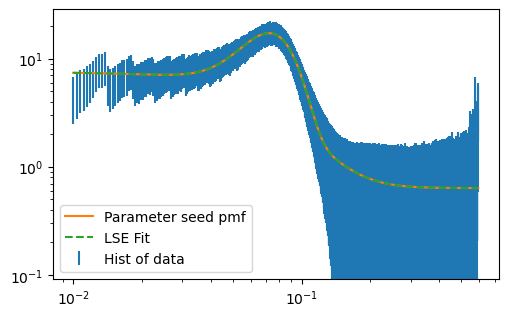

In [60]:
study_data = evs

study_xmin=np.amin(study_data)
study_xmax=np.amax(study_data)

nbins = optimal_linear_nbins(study_data)

slic=(study_xmax-study_xmin)/(nbins+1)

hbins = np.arange(study_xmin, study_xmax, slic)


hst = np.histogram(study_data, bins=hbins, weights=wts)
x_hist = hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

#       kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
# seed values taken roughly from LSE above
#theta_seed = 0.1, 0.015, 0.07, 0.01, 0.1, 0.1, 0.3
# m1 => signal
# m2 => background
# m3 => uniform
# m4 => gauss

#theta_seed = kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, 0.4, 0.005, 0.1
theta_seed = kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, mLSE[0], mLSE[1], mLSE[2]

y_line = pmf(x_hist, theta_seed)
    #porod_pmf(x_hist, alpha=4.0, xmin=x_hist[0])
#y_int = porodobj.cdf(x=np.amax(x_hist), xmin=0.001, alpha=porod_alpha)
#print(y_int)


lsesum = np.sum(lse_pmf)

lsum = np.sum(y_line)
hsum = np.sum(y_hist)

yscale = hsum / lsum

y_line = y_line * yscale

lsescale = (hsum/lsesum) * (sample_lse_x.size/x_hist.size)
lse_pmf_scaled = lse_pmf # * lsescale
# It's actually already normalised, since we are ignoring the scale parameter

plt.errorbar(x_hist, y_hist, yerr=e_hist, ls='None', marker='None', label='Hist of data')
plt.plot(x_hist, y_line, label='Parameter seed pmf')
plt.plot(lse_x, lse_pmf_scaled, ls='--', label='LSE Fit')
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [61]:
# subsample for speed

subsample_size=80000
nevents = evs.size

rng = np.random.default_rng()
elements = rng.choice(nevents, subsample_size)

subsample = evs[elements]
subweights = wts[elements]
print(subsample.shape)
print(subweights.shape)

(80000,)
(80000,)


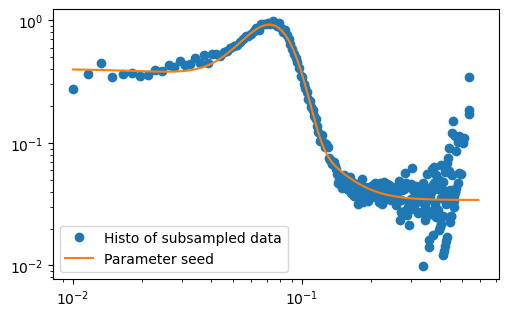

In [62]:
event_xmin = np.amin(subsample)
event_xmax = np.amax(subsample)

nbins = optimal_linear_nbins(subsample)

slic=(event_xmax-event_xmin)/(nbins+1)

hbins = np.arange(event_xmin, event_xmax, slic)


hst = np.histogram(subsample, bins=hbins, weights=subweights)
x_hist = hst[1]
x_hist = x_hist[:-1]
y_hist = hst[0]
e_hist = np.sqrt(y_hist)

#       kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
# seed values taken roughly from LSE above
theta_seed = kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, mLSE[0], mLSE[1], mLSE[2]

y_line = pmf(x_hist, theta_seed)
    #porod_pmf(x_hist, alpha=4.0, xmin=x_hist[0])
#y_int = porodobj.cdf(x=np.amax(x_hist), xmin=0.001, alpha=porod_alpha)
#print(y_int)

lsum = np.sum(y_line)
hsum = np.sum(y_hist)

yscale = hsum / lsum

y_line = y_line * yscale


plt.plot(x_hist, y_hist, ls='None', marker='o', label='Histo of subsampled data')
plt.plot(x_hist, y_line, label='Parameter seed')
plt.yscale('log')
plt.xscale('log')
plt.legend()

study_data = subsample
study_weights = subweights

In [63]:

import emcee

ndim, nwalkers = 7, 32

p0 = theta_seed
p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location
print("Burn in:")
state = sampler.run_mcmc(p0, 50, progress=True)

# Run the production chain.
sampler.reset()
print("Sampling:")
sampler.run_mcmc(state, 200, progress=True);

Burn in:


  0%|                                                    | 0/50 [00:00<?, ?it/s]/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 46%|███████████████████▊                       | 23/50 [00:03<00:04,  6.00it/s]/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_1428/3583061325.py:129: RuntimeWarning: divide by zero encountered in log
  lgauss = np.log(gauss)
100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  6.37it/s]


Sampling:


100%|█████████████████████████████████████████| 200/200 [00:29<00:00,  6.78it/s]


In [ ]:
# Ouch that is slow for the full data
# 16 seconds per iteration on a 2022 MBP (M1)
# Still, it's a big-ish data set so I used subsampling to get it down just for testing
# That makes almost 2 hours for 200 point burn in plus 200 point sampling.
# It's almost like working on monte-carlo again.
# However, it's running on only one core, can probably multi-core it to get it down to < 0.5 hrs.

192
[0.59267749 0.02676389 0.05006311 0.35272932 0.14478585 0.11908801
 0.61274781]


Text(0.5, 0, 'Q (Å-1)')

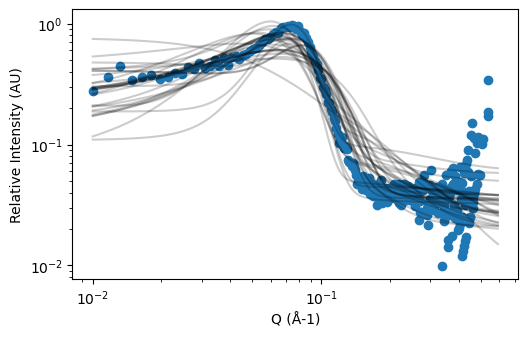

In [64]:
# Population based fit of the data

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

print(len(flat_samples))

inds = np.random.randint(len(flat_samples), size=30)

pt_sum = np.sum(y_hist)

xfit_min = np.amin(study_data)
xfit_max = np.amax(study_data)

x_fit = np.linspace(xfit_min, xfit_max, 1000)

fig, ax = plt.subplots()


for ind in inds:
    sample = flat_samples[ind]
    y_fit = pmf(x_fit, sample)

    #pt_sum = np.sum(y_fit)
    y_check = pmf(x_hist, sample)
    ysum = np.sum(y_check)
    scale = pt_sum / ysum
    y_fit = y_fit * scale
    if ind == inds[0]:
        print(sample)

    ax.plot(x_fit, y_fit, color='black', alpha = 0.2)# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
ax.scatter(x_hist, y_hist)#, c=get_weights(xvals, flat_samples[inds[0]]), cmap='viridis')
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')
#cbar = fig.colorbar(sct)
#cbar.ax.set_ylabel('Point Signal Weight')




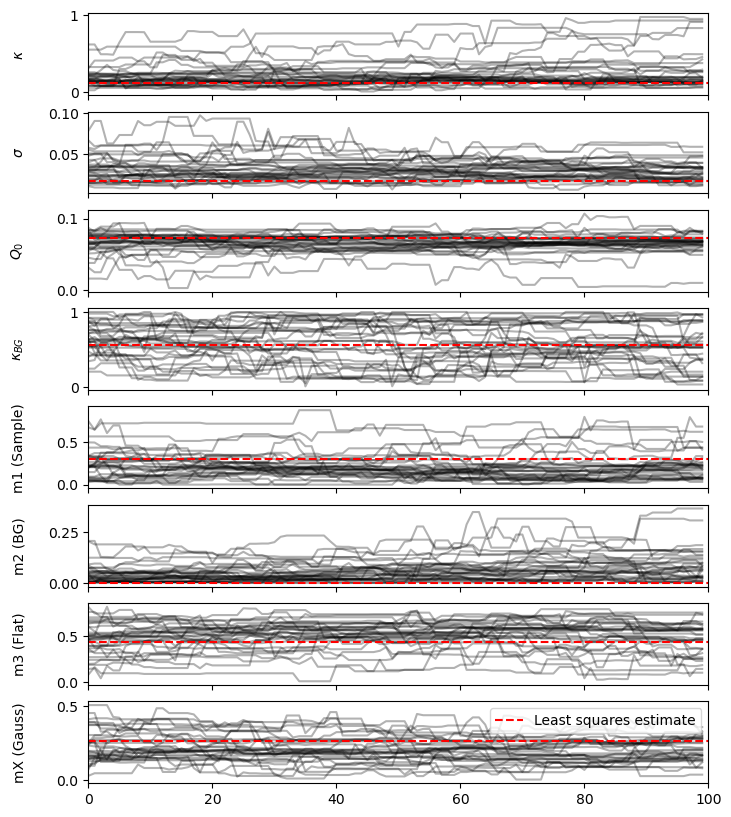

In [65]:
# Plot the theta curves during sampling 
fig, axes = plt.subplots(ndim+1, figsize=(8, 10), sharex=True)
samples = sampler.get_chain(discard=100)

mX = 1.0 - samples[:,:,4] - samples[:,:,5] - samples[:,:,6]

#       kappaSample, sigma, q0, kappaBG, m1, m2, m3 = theta
labels = ["$\kappa$", "$\sigma$", "$Q_0$", "$\kappa_{BG}$", "m1 (Sample)", "m2 (BG)", "m3 (Flat)"]
lsvals=np.array([kappaSampleLSE, sigmaLSE, q0LSE, kappaBGLSE, mLSE[0], mLSE[1], mLSE[2]])
#truevals=np.array([true_kappa, np.log10(porod_events.size / (porod_events.size + curv.data.size))])
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.hlines(lsvals[i], 0, samples[:,:,i].size, color='r', ls='--', label='Least squares estimate')
    #ax.hlines(truevals[i], 0, samples[:,:,i].size, color='g', ls='-', label='True value')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

ax = axes[7]
ax.plot(mX, "k", alpha=0.3)
ax.set_ylabel("mX (Gauss)")
ax.hlines(1.0-mLSE[0]-mLSE[1]-mLSE[2], 0, samples[:,:,i].size, color='r', ls='--', label='Least squares estimate')
ax.set_xlim(0, len(samples))
ax.yaxis.set_label_coords(-0.1, 0.5)
ax.legend()


plt.savefig('MCMC-samples.png', bbox_inches='tight')
plt.show()

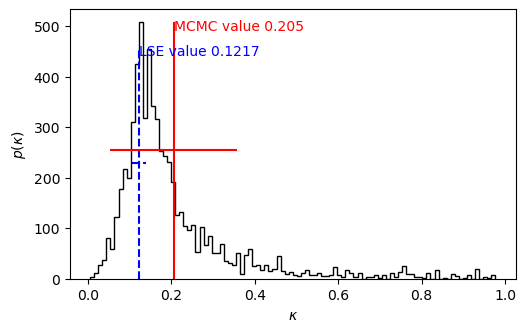

Acceptance fraction is possibly low: 0.37296875 (should be at high end of range 0.0--1.0)
kappa estimate       : 0.20504773159905226
kappa std.dev.       : 0.15115280535253706


In [66]:
samples=sampler.get_chain(flat=True)

kappa_mean = np.mean(samples[:,0])
kappa_stddev = np.std(samples[:,0])

barmin = kappa_mean - kappa_stddev
barmax = kappa_mean + kappa_stddev



lstxt   = "LSE value " + str(round(kappaSampleLSE,4))
fittxt = "MCMC value " + str(round(kappa_mean,4))

hst=plt.hist(samples[:,0], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("$\kappa$")
plt.ylabel("$p(\kappa)$")
#plt.vlines(true_kappa, 0, ytop*0.8, color='g')
plt.vlines(kappaSampleLSE, 0, ytop*0.9, ls='--', color='b')
plt.vlines(kappa_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.9*0.5, xmin=kappaSampleLSE-kappaSampleLSEe, xmax=kappaSampleLSE+kappaSampleLSEe, ls='--', color='b')
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
#plt.text(true_kappa*1.005, ytop*0.77, truetxt, color="g")
plt.text(kappaSampleLSE*1.005, ytop*0.87, lstxt, color="b")
plt.text(kappa_mean*1.005, ytop*0.97, fittxt, color="red")

plt.savefig('kappa-distribution.png', bbox_inches='tight')
plt.show()

# Get quality of fit statistic from sampler
afrac = np.mean(sampler.acceptance_fraction)


introtxt = ""
if afrac < 0.6:
    introtxt = "is possibly low:"

print("Acceptance fraction", introtxt, np.mean(sampler.acceptance_fraction), "(should be at high end of range 0.0--1.0)")

print("kappa estimate       :", kappa_mean)#, " (true value =", true_kappa,")")
print("kappa std.dev.       :", kappa_stddev)

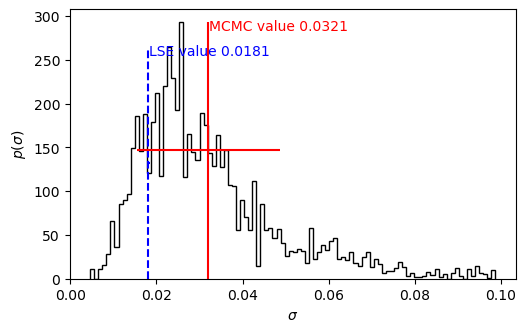

In [67]:
sigma_mean = np.mean(samples[:,1])
sigma_stddev = np.std(samples[:,1])

barmin = sigma_mean - sigma_stddev
barmax = sigma_mean + sigma_stddev



lstxt   = "LSE value " + str(round(sigmaLSE,4))
fittxt = "MCMC value " + str(round(sigma_mean,4))

hst=plt.hist(samples[:,1], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
#plt.vlines(true_kappa, 0, ytop*0.8, color='g')
plt.vlines(sigmaLSE, 0, ytop*0.9, ls='--', color='b')
plt.vlines(sigma_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.9*0.5, xmin=sigmaLSE-sigmaLSEe, xmax=sigmaLSE+sigmaLSEe, ls='--', color='b')
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
#plt.text(true_kappa*1.005, ytop*0.77, truetxt, color="g")
plt.text(sigmaLSE*1.005, ytop*0.87, lstxt, color="b")
plt.text(sigma_mean*1.005, ytop*0.97, fittxt, color="red")

plt.savefig('sigma-distribution.png', bbox_inches='tight')
plt.show()

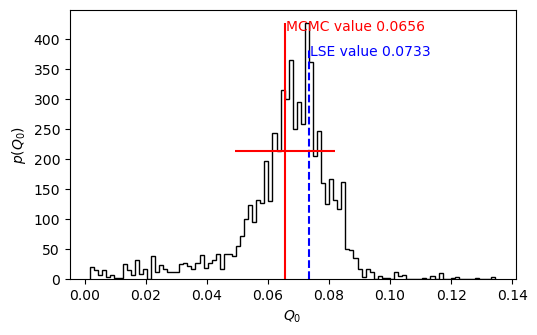

In [68]:
q0_mean = np.mean(samples[:,2])
q0_stddev = np.std(samples[:,2])

barmin = q0_mean - q0_stddev
barmax = q0_mean + q0_stddev



lstxt   = "LSE value " + str(round(q0LSE,4))
fittxt = "MCMC value " + str(round(q0_mean,4))

hst=plt.hist(samples[:,2], 100, color='k', histtype="step")
ytop = np.amax(hst[0])
plt.xlabel("$Q_0$")
plt.ylabel("$p(Q_0)$")
#plt.vlines(true_kappa, 0, ytop*0.8, color='g')
plt.vlines(q0LSE, 0, ytop*0.9, ls='--', color='b')
plt.vlines(q0_mean, 0, ytop, color="red")
plt.hlines(y=ytop*0.9*0.5, xmin=q0LSE-q0LSEe, xmax=q0LSE+q0LSEe, ls='--', color='b')
plt.hlines(y=ytop*0.5, xmin=barmin, xmax=barmax, color="red")
#plt.xlim([true_kappa*0.7, true_kappa*1.3])
#plt.text(true_kappa*1.005, ytop*0.77, truetxt, color="g")
plt.text(q0LSE*1.005, ytop*0.87, lstxt, color="b")
plt.text(q0_mean*1.005, ytop*0.97, fittxt, color="red")

plt.savefig('q0-distribution.png', bbox_inches='tight')
plt.show()